## Intorduction

Agile is an iterative approach to project management and software development that helps teams deliver a quality product with high customer satisfaction. No wonder an increasing number of companies choosing this approach as a primary way to organize their workflow. 

The crucial component to successful adoption of the agile methodology is to make sure that all members of a software development team follow the structure of a scrum meeting. A scrum meeting is a structurally fixed time-boxed stand-up meetings. Each member has about one minute to answer three questions: 

* What did they do yesterday? 
* What are they planning to do today?
* Are there any impediments?

While human evaluation of the adherence to the fixed structure of a scrum meeting has been successful there are also some disadvantages of this approach, such as human subjectivity and misunderstanding of the procedure by scrum masters. Therefore, there is a need for automatic methods for evaluation of scrum meetings which is the focus of this study.

Our approach to evaluating the quality of scrum meetings is based on the audio segmentation of audio recordings of the meetings. Specifically, we formulate the task as speaker diarization. The goal of speaker diarization is to segment continuous audio containing the speech of several speakers into several speech segments so that each speech segment only contains the speech of one speaker. 

Finally, we also propose a method to generate a text report of a scrum meeting to help the understanding of not only the structure of a scrum meeting but also its content.

## Code Settings

In this section, we installing the necessary libraries and import packages.

We will use the librosa library for extracting audio features. We also will use pydub for audio file processing and finally, we use the SpeechRecognition library for audio-to-text conversion. To use the libraries we need to install them before:

In [ ]:
%%capture 
!pip install -U librosa pydub SpeechRecognition transformers

Import packages we will use throughout the notebook:

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import pandas as pd
from pydub import AudioSegment
from pydub.playback import play
from pydub.silence import split_on_silence
import soundfile as sf
from scipy.spatial import distance
import speech_recognition as s_rec
import os 
import io
import subprocess
import nltk
from itertools import cycle, islice
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(16,8)})
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We will start with setting up the path to an mp4 file. Please note that our code is built with the the assumption that the audio file is an mp4 file and the number of speakers is know in advance:

In [ ]:
# PATH TO THE AUDIO FILE
# Note: our code is built with the the assumption 
# that the audio file is an mp4 file 
AUDIO_FILE_PATH = 'mlbd-Agile1.mp4'

# NUMBER OF SPEAKERS IN THE AUDIO
NUM_OF_SPEAKERS = 11

## Audio Features

Audio features are dicriptors of sound and they can capture differnt aspects of sound. We can use audio features as an input to a machine learning algorithm to solve various tasks such as audio classification or audio patterns discovery. 

Mel-Frequency Cepstral Coefficients (MFCCs) are the most common features for both speker segmentation and speach recognition. MFCC takes into account human perception for sensitivity at appropriate frequencies by converting the conventional frequency to Mel Scale, and are thus suitable for speech recognition tasks quite well (as they are suitable for understanding humans and the frequency at which humans speak/utter). Most common implementations take 12-13 Mel Frequency coefficients into consideration as features when training models.

Additionaly, we use PCA as a feature selection technique for identifying optimal features.

To provide some invariance to the volume of the sound, we will consider the vectors $x_t$ to be normalized.

We will start with providing the playback of the original sound file and loading it a numpy array:

In [ ]:
# extracts audio from mp4 file
def get_wav_from_mp4(file):
        audio = AudioSegment.from_file(file, format="mp4")
        audio.export("audio.wav", format="wav")
        return audio

wav_audio = get_wav_from_mp4(AUDIO_FILE_PATH)

# play the audio
wav_audio

In [ ]:
# reading the audio file as numpy array with its orignal sample rate
y, sr = librosa.load(AUDIO_FILE_PATH, sr=None)

/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Below we display the waveform of the audio to visually asses the structure of the sound:

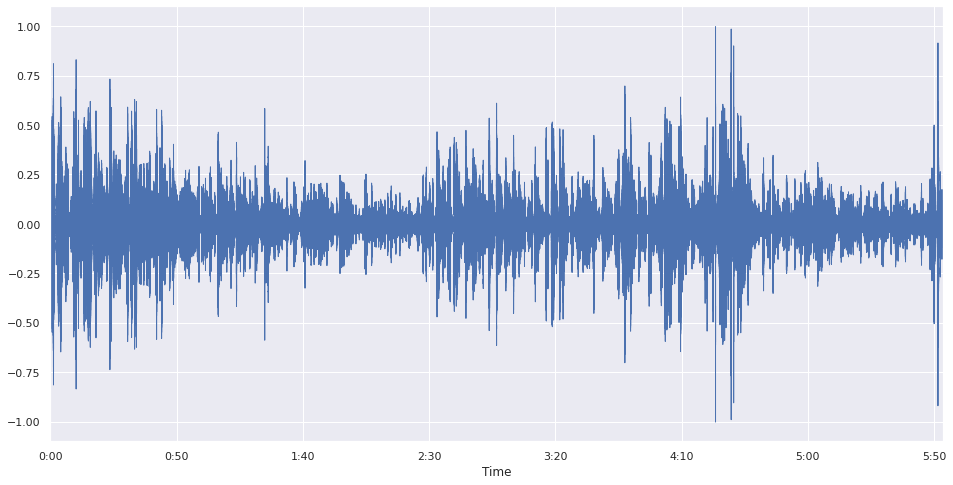

In [ ]:
# display waveform
librosa.display.waveplot(y, sr=sr);

As we can see from the graph the audio has various levels of pitch. Additionaly, we can see that the audio has a lot of noise as there is no any flat segments. The presense of noise might impact the accuracy of the algorithm.

Below we create a dataset consisting of 13 MFCC for each second of the audio:

In [ ]:
# Compute mfcc features
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Normalize the features 
#mfcc = librosa.util.normalize(mfcc, axis=1)

# Create dataset
data_df = pd.DataFrame()
for index, col in enumerate(mfcc):
    data_df[f'mfcc_{index+1}'] = col

# Add time for each feature in seconds
data_df['time_sec'] = librosa.frames_to_time(np.arange(0,mfcc.shape[1]),sr=sr)

X = data_df.drop('time_sec',axis=1).to_numpy()
data_df

mfcc_1      mfcc_2     mfcc_3  ...   mfcc_12    mfcc_13    time_sec
0     -564.626038    0.000000   0.000000  ...  0.000000   0.000000    0.000000
1     -564.626038    0.000000   0.000000  ...  0.000000   0.000000    0.011610
2     -250.569412  123.719780 -24.625099  ... -9.375858 -17.069767    0.023220
3     -154.637070  132.771912 -43.748985  ... -5.449973 -23.117186    0.034830
4     -171.110306  133.914993 -58.467056  ... -2.988411 -23.504574    0.046440
...           ...         ...        ...  ...       ...        ...         ...
30454 -282.096497  113.882690 -37.780312  ... -4.636930  -0.549031  353.570249
30455 -280.563965  112.540817 -39.808575  ... -4.454333   2.043585  353.581859
30456 -243.432922  115.738159 -63.971115  ... -4.482405  -4.250439  353.593469
30457 -236.737747  118.565018 -67.114197  ... -5.808413  -7.885642  353.605079
30458 -312.491425  108.365555 -58.167221  ... -8.120108  -6.884668  353.616689

[30459 rows x 14 columns]

## Clustering

In this section, we evaluate three distinct clustering algorithms, namely, k-means, Gaussian mixture model and agglomerative clustering for computing meeting structure score. We will start by defining a few helper functions for plotting the clustering results and getting the characteristics of the clusters.

In [ ]:
def plot_clusters_2d(data, labels = [0]):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(labels) + 1))))
    
    plt.scatter(data[:, 0], data[:, 1], s=2, color=colors[labels])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

### Dementionality reduction

We will use the PCA dimensionality reduction technique as a feature selection method.

In [ ]:
NUM_OF_FEATURES = 3
reduced_tsne_data = PCA(n_components=NUM_OF_FEATURES).fit_transform(X)

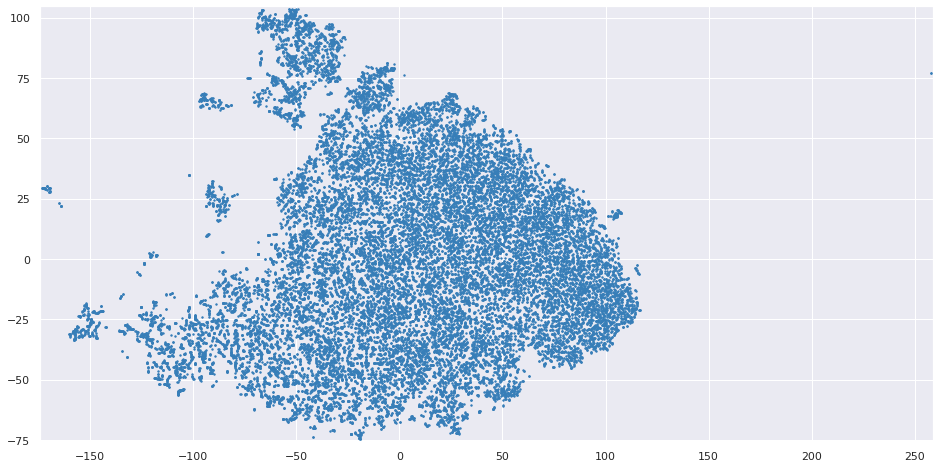

In [ ]:
# Also t-SNE is used for reducing the number of components to 2 for visualization purposes
data_2d = TSNE(n_components=2, init='pca').fit_transform(X)
plot_clusters_2d(data_2d)

### k means

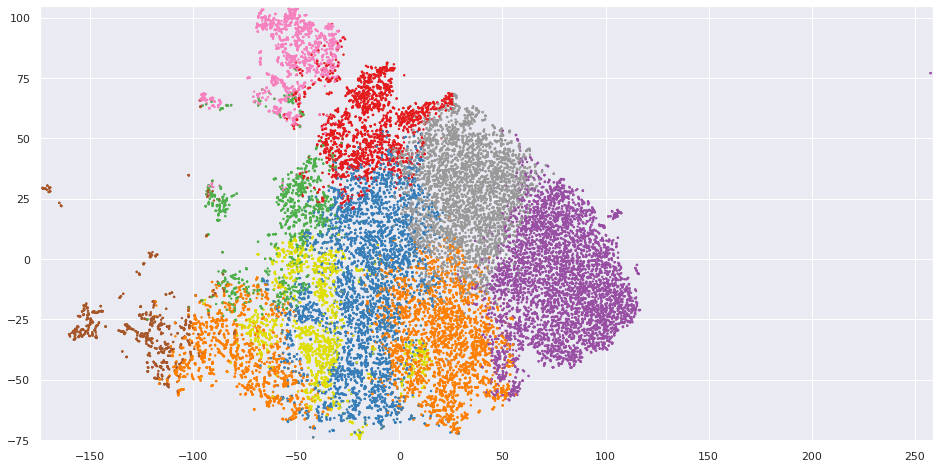

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=NUM_OF_SPEAKERS).fit(X)
plot_clusters_2d(data_2d,kmeans.labels_)

### Gaussian Mixture Model

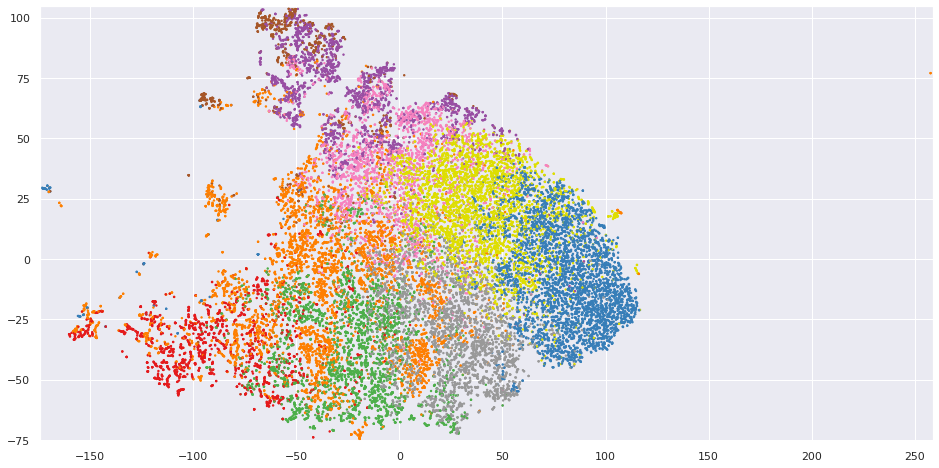

In [ ]:
gmm = GaussianMixture(n_components=NUM_OF_SPEAKERS).fit(X)
labels = gmm.predict(X)
plot_clusters_2d(data_2d,labels)

The disadvantage of k-means and GMM models that they procude non-continuous intervals. Therefore, we will use the aglomerative clustering based on the temporal connectivity graph.

### Aglomerative clustering

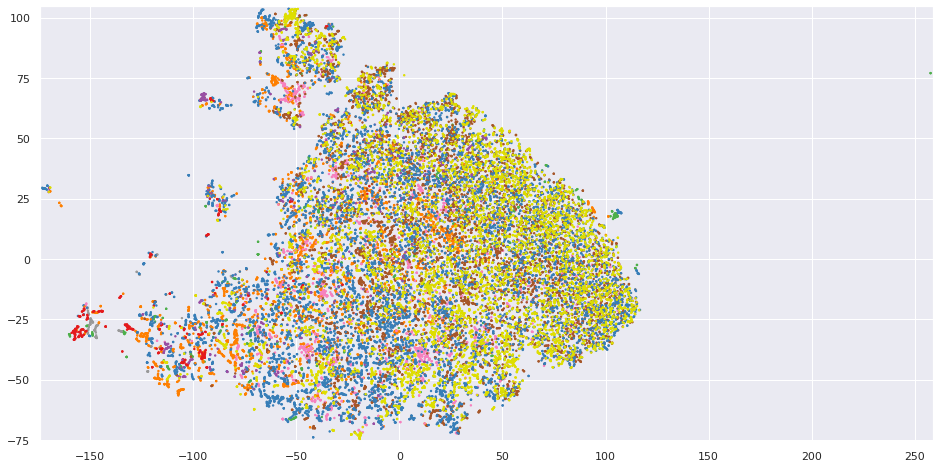

In [ ]:
# Connect the temporal connectivity graph
grid = sklearn.feature_extraction.image.grid_to_graph(n_x=len(X), n_y=1, n_z=1)
clusterer = AgglomerativeClustering(NUM_OF_SPEAKERS,connectivity=grid)
segments = librosa.segment.agglomerative(X,NUM_OF_SPEAKERS,clusterer=clusterer,axis=0)
plot_clusters_2d(data_2d,clusterer.labels_)

Getting time intervals for each speaker:

In [ ]:
data_df.iloc[segments]['time_sec'].apply(lambda x: f"{int(divmod(x, 60)[0])}:{int(divmod(x, 60)[1])}").reset_index(drop=True)

0      0:0
1      0:8
2     0:10
3     0:49
4     1:12
5     2:32
6      4:3
7      4:6
8     4:24
9     4:29
10    4:35
Name: time_sec, dtype: object

We define the folowing evaluation approach for the scrum meeting structure. The score is the proportion of participants who speaks within one minute and ranges from 0 to 100. Below we calculate the score:

In [ ]:
def calc_meeting_score(segments):
    score = 0
    for i in range(len(segments)-1):
        duration = segments.iloc[i+1] - segments.iloc[i]
        if duration < 60:
            score += 1

    return round(score/NUM_OF_SPEAKERS*100,2)

time_intervals = data_df.iloc[np.append(segments,len(data_df)-1)]['time_sec']
score = calc_meeting_score(time_intervals)

print(f"The meeting score: {score}%")

The meeting score: 72.73%


## Audio to text



In [ ]:
# create a speech recognition object
r = s_rec.Recognizer()

In [ ]:
# a function that splits the audio file into chunks
# and applies speech recognition
def get_segment_transcription(path):
  
    sound = AudioSegment.from_wav(path)  
    # split audio sound where silence is 150 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
        min_silence_len = 150,
        silence_thresh = -40,
    )
    folder_name = "audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    whole_text = ""
    error = ""
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with s_rec.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # try converting it to text
            try:
                text = r.recognize_google(audio_listened)
            except s_rec.UnknownValueError as e:
                error += str(e)
            else:
                text = f"{text.capitalize()}. "
                whole_text += text
    # return the text for all chunks detected
    return whole_text

In [ ]:
# this function returns text conversion 
def audio_segment_to_text(start_time, end_time):
  start_time_milli = start_time*1000
  end_time_milli = end_time*1000
  audio = AudioSegment.from_wav("audio.wav") 
  seg = audio[start_time_milli:end_time_milli]
  seg.export('seg.wav', format="wav")
  return get_segment_transcription('seg.wav')

Getting text from audio segments:

In [ ]:
text = [audio_segment_to_text(time_intervals.iloc[i], time_intervals.iloc[i+1])
        for i in range(len(time_intervals)-1)]

In [ ]:
# remove empty elements if any and print recognized text
text = [element for element in text if element != '']
text

['Ivana guys. ',
 'Gavin come down to. So yesterday i was working on the living on the main product page and yeah it went all right and that was running okay. ',
 "Bakery and i just was going to be at the moment so we can use the zoom in. I think i'm going to get any blockers unless we have any children every issues. Testing the shopping baskets and. ",
 "Sesame street. So it's up to somebody. So yesterday was testing and zyrtec and automated. Necromance. Yesterday i was working on the main page principle and work some of the bugs that you anyways i was looking into. I'm going to do a couple more but i think it should be okay. I basically we had some money issues things that place. Alignment. Yesterday fun lies. Design and scan well. Change request. Mydmv. ",
 'So yesterday i was working on the update. 9.7. But anyway. Nothing really sexist but. Afternoon. Salsa with tiffany 10 minutes. The song. Can you place on the bridge. Master. Next door. ',
 'And your. again tomorrow afternoon. '

Getting sentence embeddings from BERT and assign them to one of three categories:  

1. work has been done 
2. work planned to do 
3. reported issues

We will some this task as an information retrieval task where the categories are queries.

In [ ]:
from transformers import pipeline
import numpy as np
import tqdm

model_name = 'bert-base-uncased'
pipe = pipeline(task='feature-extraction', model=model_name, framework='pt',device=0)

# get sentence embeddings for a list of sentences
def get_emb(text):
    emb = {}
    for s in tqdm.notebook.tqdm(text):
        embeddings = np.array(pipe(s)).squeeze(0)
        emb[s] = embeddings[1:-1,:].mean(axis=0)
    return emb

In [ ]:
# meeting sentence embeddings
text_emb = {}
for t in [get_emb(nltk.sent_tokenize(t)) for t in text]:
    text_emb.update(t)

# query embeddings
queries = ['work has been done', 'work planned to do', 'reported issues']
query_emb = get_emb(queries)

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

# we will compute cosine similarity btween the meeting sentence and categories
def cosine_similarity(X, Y):
    return (1 - spatial.distance.cosine(X,Y))

q_k = list(query_emb.keys())
q_v = list(query_emb.values())

# sotre report
report = {q_k[0]:[],
          q_k[1]:[],
          q_k[2]:[]}

for text, s_emb in text_emb.items():
    i = np.argmax(
            np.array([cosine_similarity(s_emb, q_v[0]),
                      cosine_similarity(s_emb, q_v[1]),
                      cosine_similarity(s_emb, q_v[2])]))
    report[q_k[i]] += [text]

In [ ]:
#print the report
report

{'reported issues': ["I think i'm going to get any blockers unless we have any children every issues.",
  'Testing the shopping baskets and.',
  'So yesterday was testing and zyrtec and automated.',
  'Alignment.',
  'Yesterday fun lies.',
  'The song.',
  'And your.',
  'Site.',
  'People memes.',
  "Tucson's delete alphabet functionality."],
 'work has been done': ['So yesterday i was working on the living on the main product page and yeah it went all right and that was running okay.',
  'Sesame street.',
  "So it's up to somebody.",
  'Necromance.',
  'Yesterday i was working on the main page principle and work some of the bugs that you anyways i was looking into.',
  "I'm going to do a couple more but i think it should be okay.",
  'So yesterday i was working on the update.',
  'Dad just working on some fun and stuff yesterday.',
  'Yesterday i was working on the side in the delete button.',
  "Going very well let's see if you put them away.",
  "I'm fine today and yesterday.",
  '